# Implement a mini GPT - baseline

## Load dataset

We load the `wikitext-2-raw-v1` dataset from Hugging Face's `datasets` library.  
This version preserves the original text formatting and is suitable for unsupervised language modeling tasks.

The dataset includes:
- **Train**: 36,718 lines
- **Validation**: 3,760 lines
- **Test**: 4,358 lines

I will later concatenate these splits into a continuous corpus for training and evaluation.

In [ ]:
!pip install "nvidia-cublas-cu12==12.4.5.8" \
             "nvidia-cuda-cupti-cu12==12.4.127" \
             "nvidia-cuda-nvrtc-cu12==12.4.127" \
             "nvidia-cuda-runtime-cu12==12.4.127" \
             "nvidia-cudnn-cu12==9.1.0.70" \
             "nvidia-cufft-cu12==11.2.1.3" \
             "nvidia-curand-cu12==10.3.5.147" \
             "nvidia-cusolver-cu12==11.6.1.9" \
             "nvidia-cusparse-cu12==12.3.1.170" \
             "nvidia-nvjitlink-cu12==12.4.127" \
             --force-reinstall --no-cache-dir

In [ ]:
# Ensure the dataset is compatible with Colab
!pip uninstall -y datasets fsspec
!pip install -U datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("wikitext", "wikitext-2-raw-v1")
# print(ds)

In [ ]:
# Inspect on data
for i in range(10):
    print(f"[{i}] {ds['train'][i]['text']}")

"""
=: indicates section headers
blank lines: paragraph or section breaks
"""

[0] 
[1]  = Valkyria Chronicles III = 

[2] 
[3]  Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . 

[4]  The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more f

'\n=: indicates section headers\nblank lines: paragraph or section breaks\n'

## Corpus Preparation

To prepare the training data, I combine all available text from the original dataset (including train/val/test splits) into a single string.  
I then split the entire text **by character length** into 80% training, 10% validation, and 10% test.

In [ ]:
# Concatenate all non-empty text lines into a single string.

def prepare_and_split_corpus(ds, split_ratio=(0.8, 0.1, 0.1)):

    # Concatenate all non-empty 'text' values from train/val/test into a single string
    full_text = ""
    for split in ['train', 'validation', 'test']:
        full_text += " ".join([x['text'] for x in ds[split] if x['text'].strip() != ' '])

    # Strip any leading/trailing whitespace
    full_text = full_text.strip()

    # Calculate split indices based on total character length
    total_len = len(full_text)
    train_end = int(split_ratio[0] * total_len)           # 80% mark
    val_end = train_end + int(split_ratio[1] * total_len) # 80% + 10% = 90% mark

    # Slice the text into train, val, and test sets
    train_text = full_text[:train_end]
    val_text = full_text[train_end:val_end]
    test_text = full_text[val_end:]

    return train_text, val_text, test_text


In [ ]:
train_text, val_text, test_text = prepare_and_split_corpus(ds)

## Tokenizer Implementation

Train a Custom BPE Tokenizer using Hugging Face's tokenizers library

In [ ]:
!pip install tokenizers

### Pre-tokenization: Whitespace Split

Start by tokenizing the raw training text using a simple whitespace tokenizer.  
This step is not meant for model input but is necessary to save text into a file for training the BPE tokenizer.

In [ ]:
# Split the text into a list of tokens using simple whitespace separation.
def tokenize(text):
    """
    A basic tokenizer and does not handle punctuation or subwords.
    """
    return text.split()

train_tokens = tokenize(train_text)

In [ ]:
# Save to file
with open("train_text.txt", "w", encoding="utf-8") as f:
    f.write(train_text)

### Train a Custom BPE Tokenizer

Initialize and train a Byte-Pair Encoding (BPE) tokenizer from scratch using the Hugging Face `tokenizers` library.

- Vocabulary size: 8000
- Pre-tokenizer: Whitespace
- Special tokens: `<PAD>`, `<UNK>`, `<BOS>`, `<EOS>`

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

# Initialize a blank BPE tokenizer
tokenizer = Tokenizer(BPE())
trainer = BpeTrainer(
    vocab_size=8000,
    min_frequency=2,
    special_tokens=["<PAD>", "<UNK>", "<BOS>", "<EOS>"]
)
tokenizer.pre_tokenizer = Whitespace()

# Train tokenizer
tokenizer.train(files=["train_text.txt"], trainer=trainer)

# Save it for later use
tokenizer.save("bpe_tokenizer.json")


### Test Tokenizer on Sample Input

Load the saved tokenizer and encode a sample sentence to verify that it produces expected subword units and token IDs.

In [ ]:
# Load and test the tokenizer
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("bpe_tokenizer.json")

sample_text = "The quick brown fox jumps over the lazy dog."
encoded = tokenizer.encode(sample_text)

print("Tokens:", encoded.tokens)
print("IDs:", encoded.ids)

Tokens: ['The', 'quick', 'brown', 'fox', 'jum', 'ps', 'over', 'the', 'l', 'az', 'y', 'dog', '.']
IDs: [1057, 3199, 4850, 5285, 7055, 2273, 1160, 1018, 79, 1675, 92, 5936, 17]


In [ ]:
# Conduct Tokenization Coverage Test on validation data

def compute_coverage(tokenizer, dataset, sample_size=1000):
    total_tokens = 0
    covered_tokens = 0
    unk_token = "<UNK>"

    for i, example in enumerate(dataset):
        if i >= sample_size:
            break
        text = example["text"]
        if not text.strip():
            continue

        # Encode
        encoded = tokenizer.encode(text)
        total_tokens += len(encoded.tokens)

        # Count how many tokens are not UNK
        covered_tokens += sum(1 for t in encoded.tokens if t != unk_token)

    coverage = (covered_tokens / total_tokens) * 100 if total_tokens > 0 else 0
    return coverage

coverage = compute_coverage(tokenizer, ds["validation"])
print(f"Tokenizer vocabulary coverage on validation set: {coverage:.2f}%")

Tokenizer vocabulary coverage on validation set: 100.00%


A high coverage indicates the tokenizer is well-trained on the training corpus.

In [ ]:
# Inspect Learned Subwords
vocab = tokenizer.get_vocab() # returns a dict of {token: id}
print("Total vocab size:", len(vocab))
print("Sample subwords:", list(vocab.keys())[:20])

Total vocab size: 8000
Sample subwords: ['indicate', 'Storm', 'aces', 'card', 'ores', ',', 'Inter', 'ement', 'Missouri', 'it', 'population', 'Mer', 'today', 'τ', '今', 'pitched', 'έ', 'achieve', 'გ', 'been']


Observe the generalization to Unseen Words

In [ ]:
output = tokenizer.encode("ChatGPT") # how the tokenizer generalize to unseen word
print("Tokens:", output.tokens)

Tokens: ['Ch', 'at', 'G', 'P', 'T']


### Encode Full Corpus into Token IDs

We convert all split texts (train/val/test) into sequences of token IDs using the trained tokenizer.

In [ ]:
# Encode text into IDs using the trained BPE tokenizer

def encode_text_str(tokenizer, text):
    return tokenizer.encode(text).ids

train_ids = encode_text_str(tokenizer, train_text)
val_ids   = encode_text_str(tokenizer, val_text)
test_ids  = encode_text_str(tokenizer, test_text)

From the token ID sequences, create sliding windows of fixed block size where:
- `input = tokens[i:i+block_size]`
- `target = tokens[i+1:i+block_size+1]`

In [ ]:
# Create input–target pairs

def build_input_target_pairs(token_ids, block_size=32):
    """
    input: a sequence of `block_size` tokens;
    target: the next token to predict.
    """
    inputs, targets = [], []
    for i in range(len(token_ids) - block_size):
        input_seq = token_ids[i:i+block_size]
        target_seq = token_ids[i+1:i+block_size+1]
        inputs.append(input_seq)
        targets.append(target_seq)
    return inputs, targets

train_X, train_y = build_input_target_pairs(train_ids)
val_X, val_y     = build_input_target_pairs(val_ids)

### Wrap Data into PyTorch Dataset & DataLoader

Wrap tokenized sequences into a PyTorch `Dataset` class and use `DataLoader` to feed batches during training.  
Each batch contains:
- `input_ids`: token sequences
- `target`: next-token sequences (shifted by 1)

In [ ]:
# Create a PyTorch Dataset
import torch
from torch.utils.data import Dataset

class LanguageModelingDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.inputs[idx], dtype=torch.long),
            'target': torch.tensor(self.targets[idx], dtype=torch.long)
        }

# Create Dataset objects
train_dataset = LanguageModelingDataset(train_X, train_y)
val_dataset   = LanguageModelingDataset(val_X, val_y)

test_X, test_y = build_input_target_pairs(test_ids)
test_dataset = LanguageModelingDataset(test_X, test_y)

**Ensure for each epoch, the dataloader will shuffle the data. Increase data adversity.**

In [ ]:
# Wrap in DataLoaders and also shuffle the data
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=16, pin_memory=True )
val_loader   = DataLoader(val_dataset, batch_size=128, num_workers=16, pin_memory=True )

In [ ]:
batch = next(iter(train_loader))

print("Input shape:", batch['input_ids'].shape)
print("Target shape:", batch['target'].shape)

Input shape: torch.Size([128, 32])
Target shape: torch.Size([128, 32])


## Implement transformer model

#### Input Embedding with Positional Encoding

The `EmbeddingLayer` converts token IDs into dense vectors and adds learnable positional embeddings, allowing the model to incorporate token position information.
A dropout layer is applied to regularize the embedding output.

In [ ]:
# Input embedding with positional
import torch
import torch.nn as nn
import math

class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Embedding(block_size, embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T = x.size()
        pos = torch.arange(0, T, device=x.device).unsqueeze(0)  # shape (1, T)
        tok = self.token_embed(x)       # (B, T, D)
        pos = self.pos_embed(pos)       # (1, T, D)
        return self.dropout(tok + pos)  # (B, T, D)

#### Multi-Head Self-Attention

Implement dot-product multi-head attention.  
It projects input embeddings into queries, keys, and values using a single linear layer, then splits them into multiple heads.

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, n_heads):
        super().__init__()
        assert embed_dim % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads

        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, return_attn=False, head_mask=None):
        B, T, C = x.size()
        qkv = self.qkv_proj(x)
        q, k, v = qkv.chunk(3, dim=-1)

        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn = torch.softmax(scores, dim=-1)

        if head_mask is not None:
            # head_mask shape: (num_heads,) with 1 for active, 0 for masked
            mask = head_mask.view(1, -1, 1, 1)  # (1, H, 1, 1)
            attn = attn * mask  # masked heads all times 0
            attn = attn / (attn.sum(dim=-1, keepdim=True) + 1e-8)  # renormalize

        out = attn @ v
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.out_proj(out)

        return (out, attn) if return_attn else out

#### Position-wise Feed-Forward Network

The `FeedForward` layer applies a two-layer MLP with ReLU activation and dropout.  
It is applied independently to each position in the sequence.  

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.ff(x)

#### Transformer Block

Each `TransformerBlock` consists of:
1. LayerNorm → Multi-head Self-Attention → Residual connection  
2. LayerNorm → Feed-Forward Network → Residual connection  

Each block optionally returns attention maps for interpretability.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, n_heads, hidden_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.attn = SelfAttention(embed_dim, n_heads)
        self.ff = FeedForward(embed_dim, hidden_dim)

    def forward(self, x, return_attn=False, head_mask=None):
        if return_attn:
          attn_out, attn = self.attn(self.ln1(x), return_attn=True, head_mask=head_mask)
          x = x + attn_out
          x = x + self.ff(self.ln2(x))
          return x, attn
        else:
          x = x + self.attn(self.ln1(x), head_mask=head_mask)
          x = x + self.ff(self.ln2(x))
          return x

#### GPT Model: Stacked Transformer Architecture

The `GPT` class builds a transformer-based language model with the following components:
- An embedding layer (token + position)
- A stack of `TransformerBlock` layers
- Final LayerNorm and Linear head projecting to vocabulary size

In [ ]:
class GPT(nn.Module):
    def __init__(self, vocab_size, block_size, embed_dim=128, n_heads=4, n_layers=4):
        super().__init__()
        self.embed = EmbeddingLayer(vocab_size, embed_dim, block_size)
        self.block_size = block_size
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, hidden_dim=4 * embed_dim)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)

    def forward(self, input_ids, return_attn=False, head_mask=None):
        x = self.embed(input_ids)
        attn_maps = []

        for block in self.blocks:
            if return_attn:
                x_attn, attn = block.attn(block.ln1(x), return_attn=True, head_mask=head_mask)
                x = x + x_attn
                x = x + block.ff(block.ln2(x))
                attn_maps.append(attn)
            else:
                x = block(x)

        x = self.ln_f(x)
        logits = self.head(x)
        return (logits, attn_maps) if return_attn else logits

#### Loss Function

Loss computation:
- `input_ids[:, :-1]` are fed into the model
- Targets are `input_ids[:, 1:]`
- Loss is computed between logits and shifted targets

In [ ]:
# Loss function

loss_fn = nn.CrossEntropyLoss()

def compute_loss(model, batch):
    logits = model(batch['input_ids'])        # (B, T, V)
    logits = logits[:, :-1, :].contiguous()   # predict next token
    targets = batch['target'][:, 1:].contiguous()
    return loss_fn(logits.view(-1, logits.size(-1)), targets.view(-1))

## Training and evaluation loop

Baseline search train

In [ ]:
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader
import matplotlib.pyplot as plt
import math

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Training for one epoch
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        targets = batch['target'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids)

        logits = logits[:, :-1, :].contiguous()
        targets = targets[:, 1:].contiguous()

        loss = loss_fn(logits.view(-1, logits.size(-1)), targets.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
# Evaluate average loss on validation set

def evaluate_loss(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_tokens = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            targets = batch['target'].to(device)
            outputs = model(input_ids)
            outputs = outputs[:, :-1, :].contiguous()
            targets = targets[:, 1:].contiguous()

            loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            total_loss += loss.item() * targets.numel()  # Sum all token loss
            total_tokens += targets.numel()

    return total_loss / total_tokens  # Per token average loss

In [ ]:
def evaluate_perplexity(model, dataloader):
    loss = evaluate_loss(model, dataloader)
    return math.exp(loss)

In [ ]:
# Compute total gradient norm to monitor training stability

def compute_grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)  # L2 norm
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

Find the best setting for hyperparameters

In [ ]:
# Set of already-tested (lr, layers, heads, embed_dim) configs
completed_configs = {
    # (0.001, 2, 2, 64),
    # (0.001, 2, 2, 128),
    # (0.001, 2, 2, 256),
    # (0.001, 2, 4, 64),
    # (0.001, 2, 4, 128),
    # (0.001, 2, 4, 256),
    # (0.001, 4, 2, 64),
    # (0.001, 4, 2, 128),
    # (0.001, 4, 4, 128),
    # (0.001, 6, 2, 128)
}

# Manually compiled from screenshots or logs
previous_results = [
    # {'config': (0.001, 2, 2, 64),  'val_ppl': 1.17},
    # {'config': (0.001, 2, 2, 128), 'val_ppl': 1.17},
    # {'config': (0.001, 2, 2, 256), 'val_ppl': 1.17},
    # {'config': (0.001, 2, 4, 64),  'val_ppl': 1.17},
    # {'config': (0.001, 2, 4, 128), 'val_ppl': 1.17},
    # {'config': (0.001, 2, 4, 256), 'val_ppl': 1.17},
    # {'config': (0.001, 4, 2, 64),  'val_ppl': 1.17},
    # {'config': (0.001, 4, 2, 128), 'val_ppl': 1.17},
    # {'config': (0.001, 4, 4, 128), 'val_ppl': 1.17},
    # {'config': (0.001, 6, 2, 128), 'val_ppl': 1.17}
]

In [ ]:
# Main hyperparameter search function
import os
from torch.cuda.amp import autocast, GradScaler
from transformers import get_cosine_schedule_with_warmup

def hyperparameter_search(train_loader, val_loader, vocab, block_size, device, GPT,
                          completed_configs=None, save_model=False, save_dir="checkpoints/",
                          grad_accum_steps=4):
    os.makedirs(save_dir, exist_ok=True)
    scaler = GradScaler()
    loss_fn = nn.CrossEntropyLoss()
    best_ppl = float('inf')
    best_config = None
    best_results = {}

    # Search space for hyperparameters
    learning_rates = [0.001, 5e-4]
    num_layers = [2, 4, 6]
    num_heads = [2, 4]
    embed_dims = [128]

    if completed_configs is None:
        completed_configs = set()

    # Loop over all configurations
    for lr in learning_rates:
        for layers in num_layers:
            for heads in num_heads:
                for embed_dim in embed_dims:
                    if embed_dim % heads != 0:
                        continue  # skip invalid config
                    config = (lr, layers, heads, embed_dim)
                    if config in completed_configs:
                        print(f"Skipping already completed config: {config}")
                        continue

                    print(f"\nRunning config: lr={lr}, layers={layers}, heads={heads}, embed_dim={embed_dim}")
                    model = GPT(len(vocab), embed_dim, block_size, heads, layers).to(device)
                    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

                    # Set scheduler for linear warmup + cosine decay
                    total_steps = (len(train_loader) // grad_accum_steps + 1) * 10  # 10 epochs
                    warmup_steps = int(0.1 * total_steps)
                    scheduler = get_cosine_schedule_with_warmup(
                        optimizer,
                        num_warmup_steps=warmup_steps,
                        num_training_steps=total_steps
                    )

                    best_val_loss = float('inf')
                    early_stop_counter = 0
                    early_stop_patience = 2
                    max_epochs = 10

                    # Metrics tracking
                    train_losses, val_losses, val_ppls = [], [], []
                    lr_schedule, grad_norms = [], []

                    # Training loop
                    for epoch in range(max_epochs):
                        model.train()
                        total_loss = 0
                        total_tokens = 0
                        optimizer.zero_grad()

                        for step, batch in enumerate(train_loader):
                            input_ids = batch['input_ids'].to(device)
                            targets = batch['target'].to(device)

                            with autocast():
                                outputs = model(input_ids)
                                outputs = outputs[:, :-1, :].contiguous()
                                targets = targets[:, 1:].contiguous()
                                loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                                loss = loss / grad_accum_steps  # for gradient accumulation

                            scaler.scale(loss).backward()

                            # Only step when grad accumulation threshold is reached or last batch
                            if (step + 1) % grad_accum_steps == 0 or (step + 1) == len(train_loader):
                                grad_norm = compute_grad_norm(model)
                                grad_norms.append(grad_norm)

                                scaler.step(optimizer)
                                scaler.update()
                                scheduler.step()
                                lr_schedule.append(scheduler.get_last_lr()[0])  # record LR per step
                                optimizer.zero_grad()

                            # Accumulate real loss for logging (undo the division)
                            total_loss += loss.item() * targets.numel()
                            total_tokens += targets.numel()

                        # Evaluate after epoch
                        avg_train_loss = total_loss / total_tokens
                        avg_val_loss = evaluate_loss(model, val_loader, loss_fn, device)
                        val_ppl = math.exp(avg_val_loss)

                        train_losses.append(avg_train_loss)
                        val_losses.append(avg_val_loss)
                        val_ppls.append(val_ppl)

                        # Safely handle grad_norm logging
                        grad_norm_display = grad_norms[-1] if grad_norms else float('nan')
                        print(f"Epoch {epoch + 1}: Train Loss={avg_train_loss:.4f}, "
                              f"Val Loss={avg_val_loss:.4f}, Perplexity={val_ppl:.4f}, "
                              f"LR={lr_schedule[-1]:.6f}, GradNorm={grad_norm_display:.4e}")

                        # Early stopping check
                        if avg_val_loss < best_val_loss:
                            best_val_loss = avg_val_loss
                            early_stop_counter = 0
                        else:
                            early_stop_counter += 1
                            if early_stop_counter >= early_stop_patience:
                                print("Early stopping triggered.")
                                break

                    final_ppl = math.exp(best_val_loss)
                    print(f"Final Perplexity for {config}: {final_ppl:.4f}")

                    # Save best configuration and results
                    if final_ppl < best_ppl:
                        best_ppl = final_ppl
                        best_config = config
                        best_results = {
                            'train_losses': train_losses,
                            'val_losses': val_losses,
                            'val_ppls': val_ppls,
                            'lr_schedule': lr_schedule,
                            'grad_norms': grad_norms,
                            'final_val_loss': best_val_loss,
                            'final_val_ppl': final_ppl,
                            'config': best_config
                        }

                        # Optionally save model checkpoint
                        if save_model:
                            torch.save({
                                'model_state_dict': model.state_dict(),
                                'config': {
                                    'vocab_size': len(vocab),
                                    'embed_dim': embed_dim,
                                    'block_size': block_size,
                                    'num_heads': heads,
                                    'num_layers': layers,
                                    'lr': lr
                                }
                            }, os.path.join(save_dir, f"best_model_{embed_dim}d_{heads}h_{layers}l.pth"))
                            print("💾 Model saved.")

    print("\nBest Config:", best_config)
    print("Best Validation Perplexity:", best_ppl)
    return best_config, best_results

In [ ]:
block_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_config, best_results = hyperparameter_search(
    train_loader, val_loader, vocab, block_size, device, GPT,
    completed_configs=completed_configs,
    save_model=True
)


Running config: lr=0.001, layers=2, heads=2, embed_dim=128


<ipython-input-34-3570943379>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-34-3570943379>:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss=0.4271, Val Loss=0.2199, Perplexity=1.2460, LR=0.001000, GradNorm=5.5143e+03
Epoch 2: Train Loss=0.0507, Val Loss=0.1871, Perplexity=1.2057, LR=0.000970, GradNorm=3.9870e+04
Epoch 3: Train Loss=0.0444, Val Loss=0.1759, Perplexity=1.1923, LR=0.000883, GradNorm=1.7277e+05
Epoch 4: Train Loss=0.0418, Val Loss=0.1704, Perplexity=1.1858, LR=0.000750, GradNorm=3.6137e+05
Epoch 5: Train Loss=0.0403, Val Loss=0.1675, Perplexity=1.1824, LR=0.000587, GradNorm=3.5507e+05
Epoch 6: Train Loss=0.0392, Val Loss=0.1653, Perplexity=1.1798, LR=0.000413, GradNorm=1.8142e+05
Epoch 7: Train Loss=0.0385, Val Loss=0.1640, Perplexity=1.1783, LR=0.000250, GradNorm=2.0813e+05
Epoch 8: Train Loss=0.0379, Val Loss=0.1632, Perplexity=1.1773, LR=0.000117, GradNorm=4.4603e+05
Epoch 9: Train Loss=0.0375, Val Loss=0.1630, Perplexity=1.1770, LR=0.000030, GradNorm=4.2001e+05
Epoch 10: Train Loss=0.0373, Val Loss=0.1630, Perplexity=1.1770, LR=0.000000, GradNorm=4.3233e+05
Final Perplexity for (0.001, 

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1: Train Loss=0.4503, Val Loss=0.2156, Perplexity=1.2406, LR=0.001000, GradNorm=1.6833e+05
Epoch 2: Train Loss=0.0499, Val Loss=0.1863, Perplexity=1.2048, LR=0.000970, GradNorm=3.0537e+05
Epoch 3: Train Loss=0.0443, Val Loss=0.1754, Perplexity=1.1917, LR=0.000883, GradNorm=3.3257e+05
Epoch 4: Train Loss=0.0417, Val Loss=0.1700, Perplexity=1.1853, LR=0.000750, GradNorm=3.5307e+05
Epoch 5: Train Loss=0.0402, Val Loss=0.1671, Perplexity=1.1819, LR=0.000587, GradNorm=3.5756e+05
Epoch 6: Train Loss=0.0391, Val Loss=0.1651, Perplexity=1.1795, LR=0.000413, GradNorm=3.7794e+05
Epoch 7: Train Loss=0.0383, Val Loss=0.1638, Perplexity=1.1779, LR=0.000250, GradNorm=3.9061e+05
Epoch 8: Train Loss=0.0378, Val Loss=0.1632, Perplexity=1.1773, LR=0.000117, GradNorm=4.9235e+05
Epoch 9: Train Loss=0.0374, Val Loss=0.1628, Perplexity=1.1768, LR=0.000030, GradNorm=4.4322e+05
Epoch 10: Train Loss=0.0372, Val Loss=0.1629, Perplexity=1.1769, LR=0.000000, GradNorm=4.4993e+05
Final Perplexity for (0.001, 

In [ ]:
# Extract val_ppl from new results
new_val_ppl = best_results['val_ppls'][-1]

# Combine all into one list
all_results = previous_results + [
    {'config': best_config, 'val_ppl': new_val_ppl}
]

# Find the best configuration overall
best_overall = min(all_results, key=lambda x: x['val_ppl'])

print("\n Best Overall Config:", best_overall['config'])
print("Lowest Validation Perplexity:", best_overall['val_ppl'])


 Best Overall Config: (0.001, 6, 4, 128)
Lowest Validation Perplexity: 1.171097992572623


In [ ]:
import matplotlib.pyplot as plt

def plot_search_results(best_results):
    """
    Plot training/validation loss, validation perplexity, learning rate schedule,
    and gradient norm based on results from hyperparameter_search.
    """
    # Extract data
    train_losses = best_results['train_losses']
    val_losses = best_results['val_losses']
    val_ppls = best_results['val_ppls']
    lr_schedule = best_results['lr_schedule']  # step-wise
    grad_norms = best_results['grad_norms']    # step-wise

    epochs = range(1, len(train_losses) + 1)
    steps = range(1, len(lr_schedule) + 1)
    grad_steps = range(1, len(grad_norms) + 1)

    # Plot LR alone (step-wise)
    plt.figure(figsize=(8, 4))
    plt.plot(steps, lr_schedule, label='Learning Rate (per step)', color='green')
    plt.xlabel('Training Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule (Warmup + Cosine)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Combined subplots
    plt.figure(figsize=(14, 10))

    # Plot 1: Training and Validation Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Validation Perplexity
    plt.subplot(2, 2, 2)
    plt.plot(epochs, val_ppls, label='Validation Perplexity', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Validation Perplexity per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 3: Learning Rate (step-wise)
    plt.subplot(2, 2, 3)
    plt.plot(steps, lr_schedule, label='Learning Rate', color='green')
    plt.xlabel('Training Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate per Step')
    plt.legend()
    plt.grid(True)

    # Plot 4: Gradient Norm (step-wise)
    plt.subplot(2, 2, 4)
    plt.plot(grad_steps, grad_norms, label='Gradient Norm', color='orange')
    plt.xlabel('Training Step')
    plt.ylabel('L2 Norm')
    plt.title('Gradient Norm per Step')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

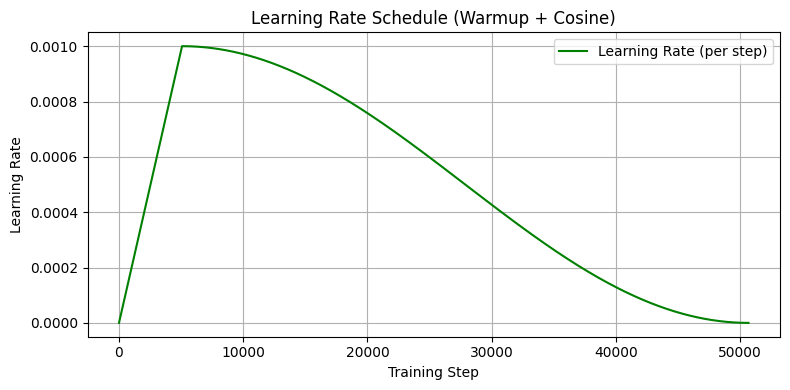

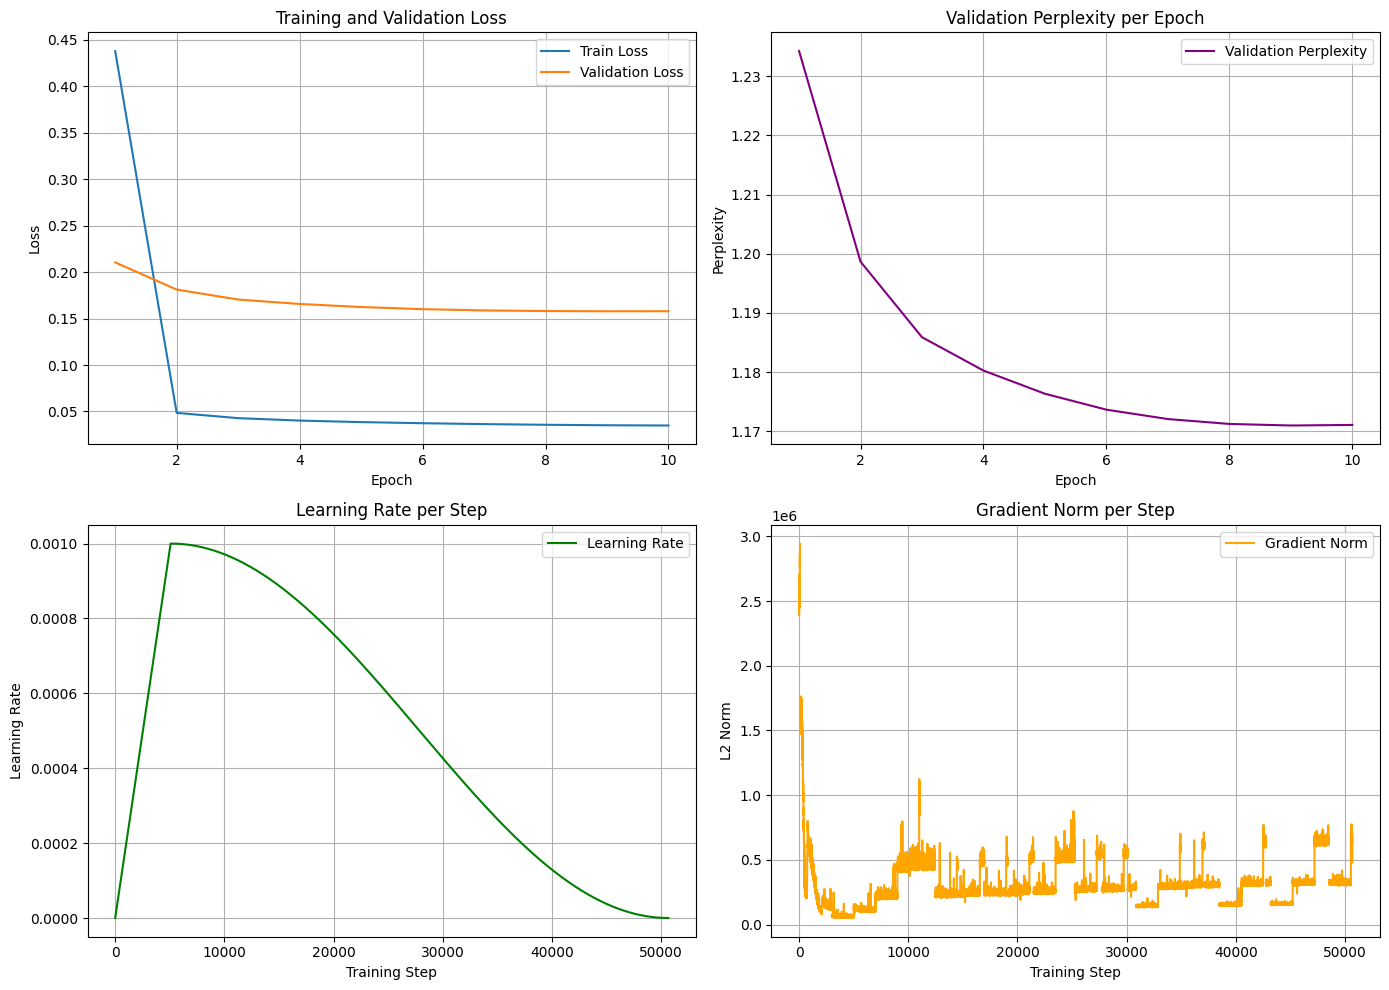

In [ ]:
plot_search_results(best_results)

Retrain the model with the best hyperparameter setting \\
Change the number of epoch to 30 instead of 10

In [ ]:
import torch
import math
import os
from torch.amp import autocast, GradScaler
from google.colab import drive

def retrain_with_best_config(train_loader, val_loader, vocab_size, block_size, device, GPT,
                             best_config, epochs=30, checkpoint_name="gpt_best_checkpoint.pt"):
    # Mount Google Drive
    drive.mount('/content/drive')
    checkpoint_dir = "/content/drive/MyDrive/gpt_checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)

    # Unpack best config
    loss_fn = torch.nn.CrossEntropyLoss()
    best_lr, best_layers, best_heads, best_embed_dim = best_config

    model = GPT(vocab_size, best_embed_dim, block_size, best_heads, best_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    scaler = GradScaler()

    start_epoch = 0
    best_val_loss = float('inf')

    # Load checkpoint if exists
    if os.path.exists(checkpoint_path):
        print(f"Found checkpoint at {checkpoint_path}, loading...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['val_loss']
        print(f"Resumed training at epoch {start_epoch} with val_loss={best_val_loss:.4f}")

    train_losses, val_losses, val_ppls, lr_schedule, grad_norms = [], [], [], [], []

    for epoch in range(start_epoch, epochs):
        print(f"\n Epoch {epoch+1} started")
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()

            with autocast(device_type=device.type):
                outputs = model(input_ids)
                outputs = outputs[:, :-1, :].contiguous()
                targets = targets[:, 1:].contiguous()
                loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))

            scaler.scale(loss).backward()

            grad_norm = compute_grad_norm(model)
            grad_norms.append(grad_norm)

            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            # if batch_idx % 50 == 0:
            #     print(f"   🧪 Batch {batch_idx} - Loss: {loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                targets = batch['target'].to(device)

                outputs = model(input_ids)
                outputs = outputs[:, :-1, :].contiguous()
                targets = targets[:, 1:].contiguous()
                loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_ppl = math.exp(avg_val_loss)
        val_ppls.append(val_ppl)
        scheduler.step(avg_val_loss)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        lr_schedule.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Perplexity: {val_ppl:.2f}, "
              f"LR: {lr_schedule[-1]:.6f}, GradNorm: {grad_norm:.4f}")

        # Save checkpoint if improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': best_val_loss
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1} with Val Loss={best_val_loss:.4f}")

    return model, train_losses, val_losses, val_ppls, lr_schedule, grad_norms

Apply test data on retrained model-test generalization

In [ ]:
def evaluate_on_test(model, test_loader, device):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            targets = batch['target'].to(device)

            outputs = model(input_ids)
            outputs = outputs[:, :-1, :].contiguous()
            targets = targets[:, 1:].contiguous()

            loss = loss_fn(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    test_ppl = math.exp(avg_loss)
    return avg_loss, test_ppl

In [ ]:
def plot_training_results(train_losses, val_losses, val_ppls, lr_schedule, grad_norms, test_perplexity):
    plt.figure(figsize=(16, 5))

    # Loss Curve
    plt.subplot(1, 4, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # Validation Perplexity
    plt.subplot(1, 4, 2)
    plt.plot(val_ppls, label='Validation Perplexity')
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.title("Validation Perplexity per Epoch")
    plt.legend()
    plt.grid(True)

    # LR Schedule
    plt.subplot(1, 4, 3)
    plt.plot(lr_schedule, label='Learning Rate')
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.title("Learning Rate Schedule")
    plt.legend()
    plt.grid(True)

    # Gradient Norm
    plt.subplot(1, 4, 4)
    plt.plot(grad_norms, label='Gradient Norm')
    plt.xlabel("Training Step")
    plt.ylabel("L2 Norm")
    plt.title("Gradient Norm per Step")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\n Final Test Perplexity: {test_perplexity:.2f}")

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=16, pin_memory=True)
vocab_size = tokenizer.get_vocab_size()

# Run retrain
model, train_losses, val_losses, val_ppls, lr_schedule, grad_norms = retrain_with_best_config(
    train_loader, val_loader, vocab_size, block_size, device, GPT, best_config, epochs=20
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found checkpoint at /content/drive/MyDrive/gpt_checkpoints/gpt_best_checkpoint.pt, loading...
Resumed training at epoch 5 with val_loss=0.1586

 Epoch 6 started
Epoch 6/20 - Train Loss: 0.1454, Val Loss: 0.1575, Perplexity: 1.17, LR: 0.001000, GradNorm: 137258.4552
Checkpoint saved at epoch 6 with Val Loss=0.1575

 Epoch 7 started
Epoch 7/20 - Train Loss: 0.1430, Val Loss: 0.1569, Perplexity: 1.17, LR: 0.001000, GradNorm: 122234.2330
Checkpoint saved at epoch 7 with Val Loss=0.1569

 Epoch 8 started
Epoch 8/20 - Train Loss: 0.1410, Val Loss: 0.1561, Perplexity: 1.17, LR: 0.001000, GradNorm: 132525.4052
Checkpoint saved at epoch 8 with Val Loss=0.1561

 Epoch 9 started
Epoch 9/20 - Train Loss: 0.1394, Val Loss: 0.1553, Perplexity: 1.17, LR: 0.001000, GradNorm: 130874.4782
Checkpoint saved at epoch 9 with Val Loss=0.1553

 Epoch 10 started
Epoch 10/20 - Train L

In [ ]:
# Evaluate on test data
test_loss, test_perplexity = evaluate_on_test(model, test_loader, device)
print(f"Final Test Loss: {test_loss:.4f}, Test Perplexity: {test_perplexity:.2f}")

Final Test Loss: 0.1530, Test Perplexity: 1.17


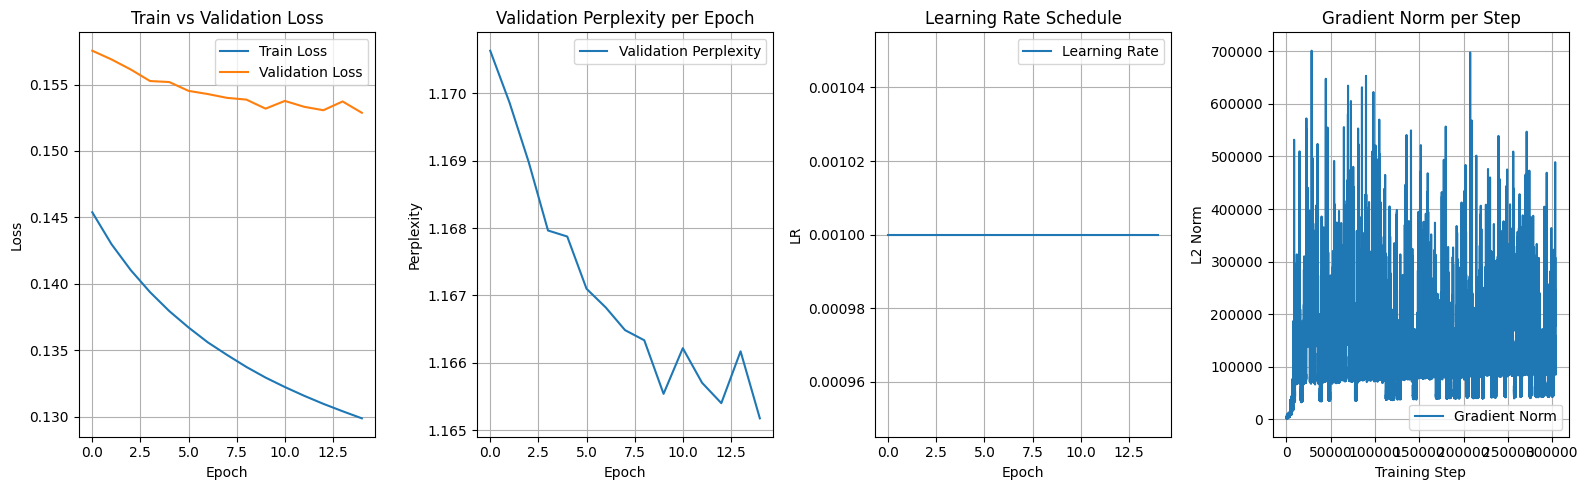


 Final Test Perplexity: 1.17


In [ ]:
# Plot training results
plot_training_results(train_losses, val_losses, val_ppls, lr_schedule, grad_norms, test_perplexity)

Interpretation: \\

**Noted: The validation loss here is not valid since I used the validation dataset in the first(hyperparameter_search function) training. The model has already seen the validation data last time, therefore the validation loss can be lower.**

1. Seems like the model continues learning/memorizing on the training set. However, we can see that validation loss flattened after 7 epoches meaching that might be limit of what the model can learn from the validation data without overfitting.
2. The plateau around epoch 10 to 13 onward indicates the model has converged or is making only marginal improvements.
3. Even though there're sime spikes in Gradient Norm, no catastrophic appeared.

In [ ]:
vocab_size = len(vocab)
best_lr, best_layers, best_heads, best_embed_dim = best_config

torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'vocab_size': vocab_size,
        'embed_dim': best_embed_dim,
        'block_size': block_size,
        'num_heads': best_heads,
        'num_layers': best_layers
    }
}, "best_gpt_model_with_config.pth")

## Visulize attention heatmap

In [ ]:
# Load the model with the best hyperparameters
from tokenizers import Tokenizer

# Load a text and the tokenizer
tokenizer = Tokenizer.from_file("bpe_tokenizer.json")
text = "The cat sat on the mat"

ids = tokenizer.encode(text).ids   # [17, 250, 456, 32, 17, 987]
input_ids = torch.tensor([ids])

# get the model setting back
checkpoint = torch.load("best_gpt_model_with_config.pth")

config = checkpoint['config']
model = GPT(
    vocab_size=config['vocab_size'],
    block_size=config['block_size'],
    embed_dim=config['embed_dim'],
    n_heads=config['num_heads'],
    n_layers=config['num_layers']
)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

with torch.no_grad():
    logits, attn_maps = model(input_ids, return_attn=True)

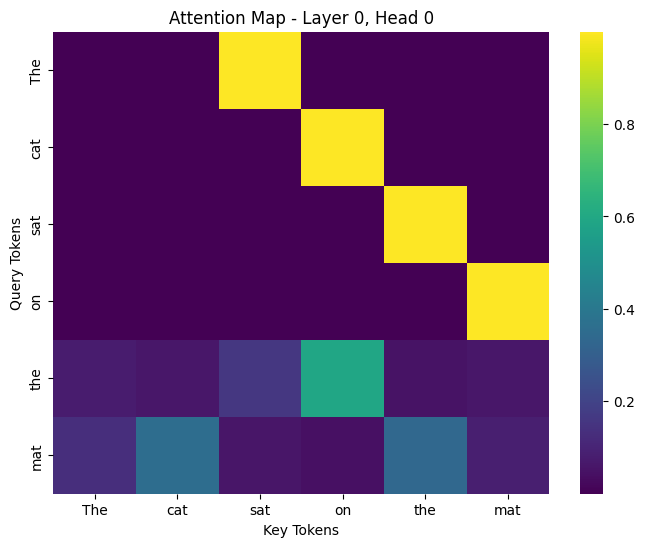

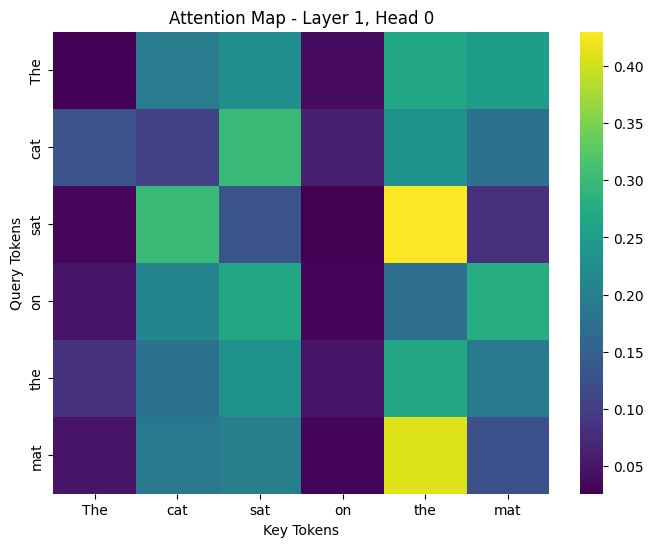

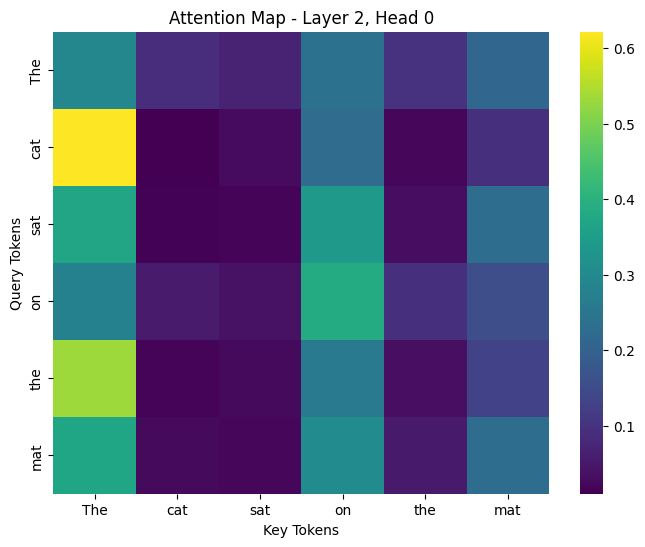

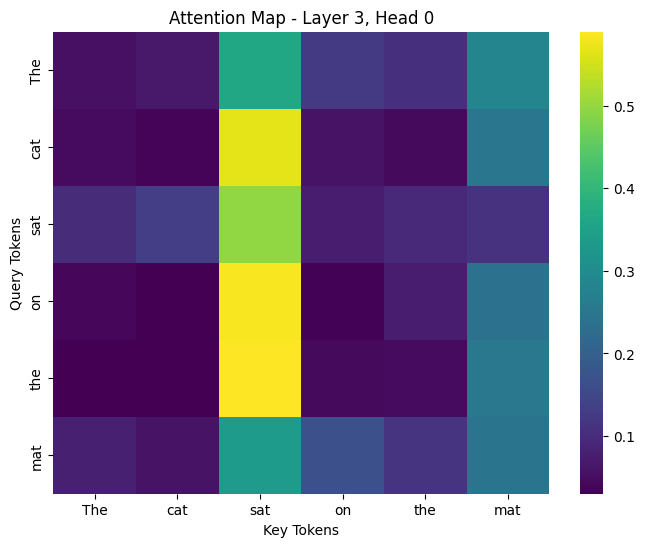

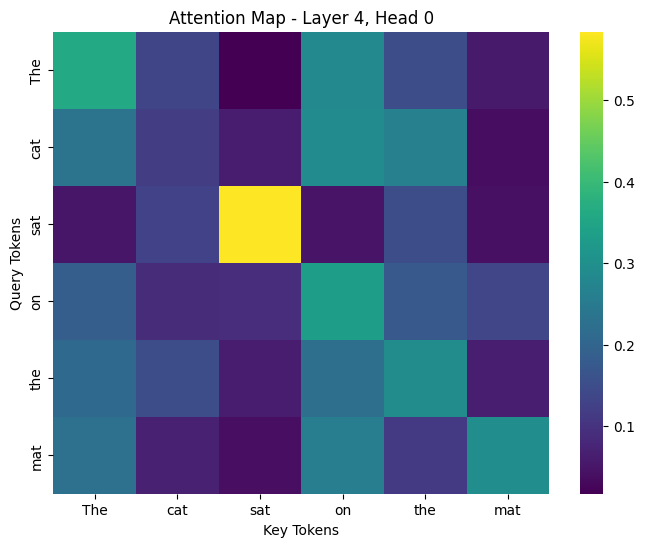

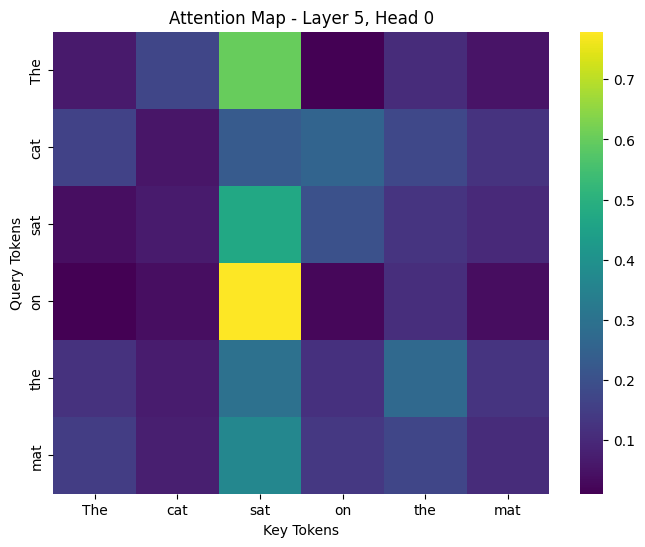

In [ ]:
import seaborn as sns

def plot_attention(attn_maps, layer=0, head=0, tokens=None):
    attn = attn_maps[layer][0, head].detach().cpu().numpy()  # (seq_len, seq_len)
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, cmap="viridis", xticklabels=tokens, yticklabels=tokens)
    plt.title(f"Attention Map - Layer {layer}, Head {head}")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.show()

# decode tokens
tokens = tokenizer.encode(text).tokens

# plot
plot_attention(attn_maps, layer=0, head=0, tokens=tokens)
plot_attention(attn_maps, layer=1, head=0, tokens=tokens)
plot_attention(attn_maps, layer=2, head=0, tokens=tokens)
plot_attention(attn_maps, layer=3, head=0, tokens=tokens)
plot_attention(attn_maps, layer=4, head=0, tokens=tokens)
plot_attention(attn_maps, layer=5, head=0, tokens=tokens)

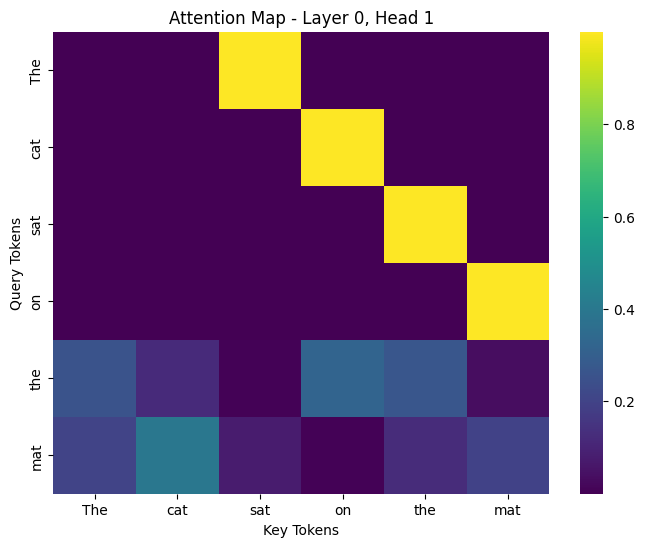

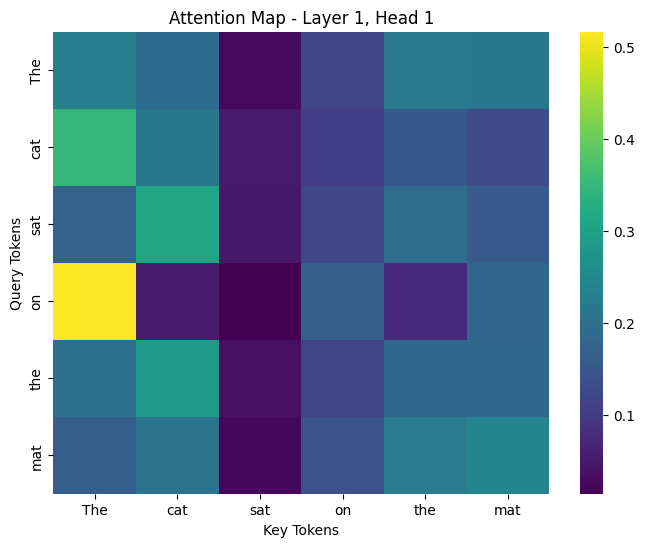

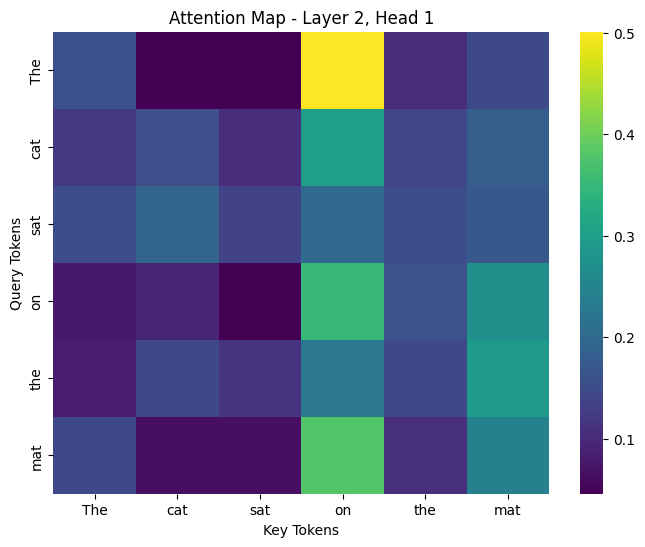

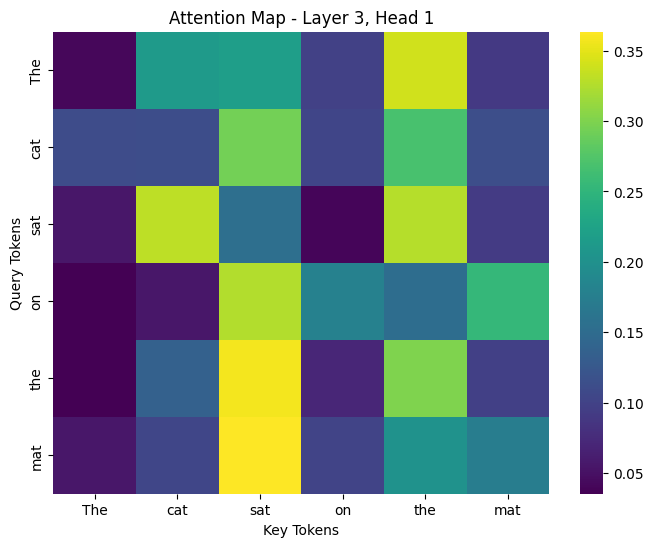

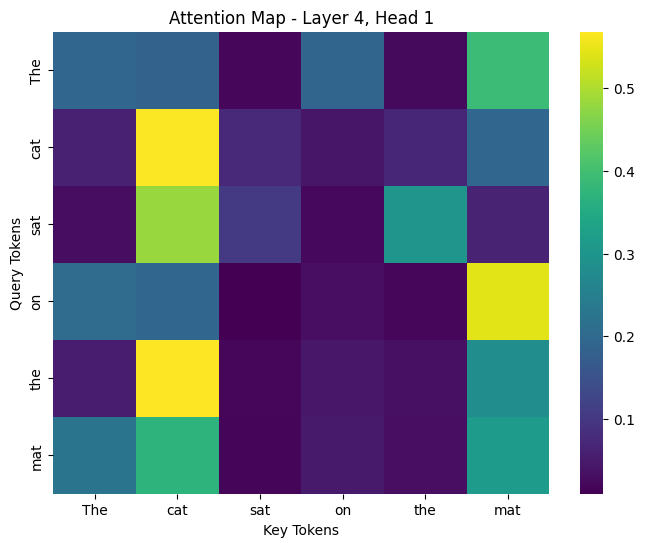

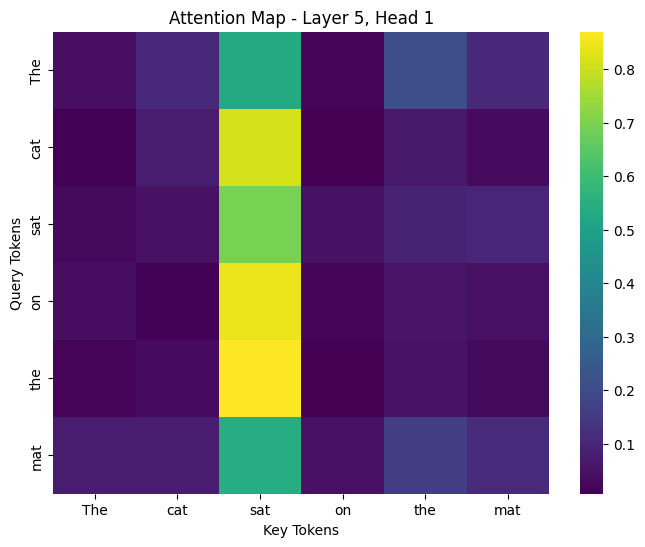

In [ ]:
plot_attention(attn_maps, layer=0, head=1, tokens=tokens)
plot_attention(attn_maps, layer=1, head=1, tokens=tokens)
plot_attention(attn_maps, layer=2, head=1, tokens=tokens)
plot_attention(attn_maps, layer=3, head=1, tokens=tokens)
plot_attention(attn_maps, layer=4, head=1, tokens=tokens)
plot_attention(attn_maps, layer=5, head=1, tokens=tokens)

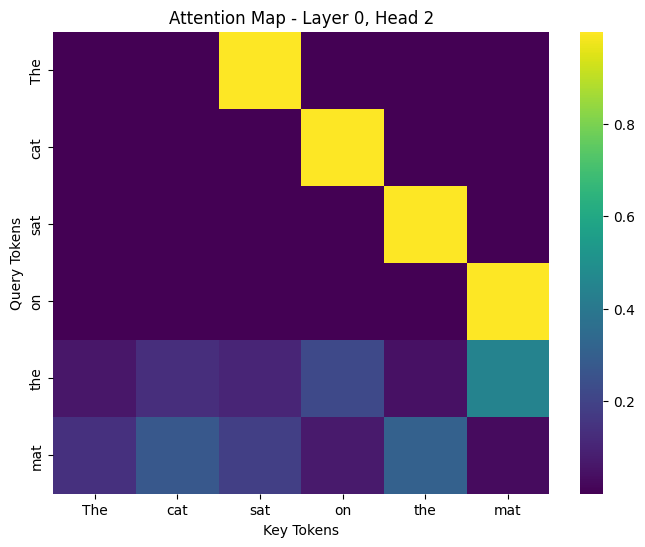

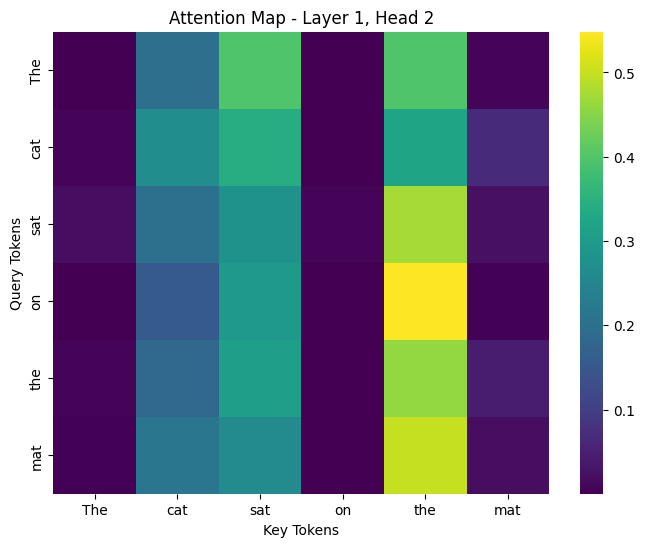

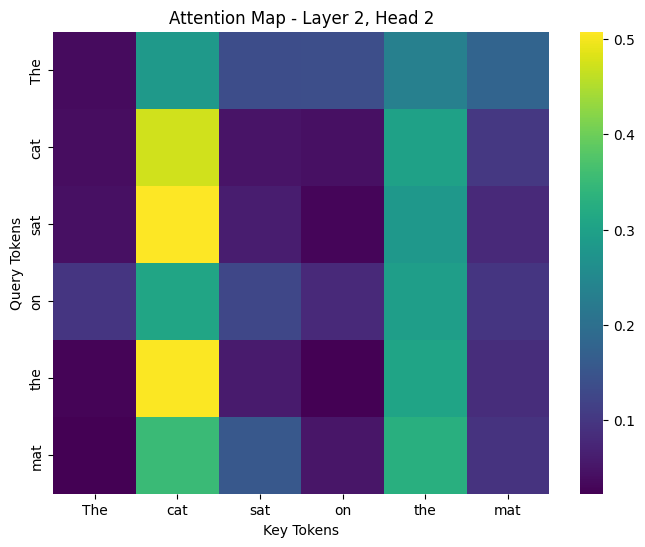

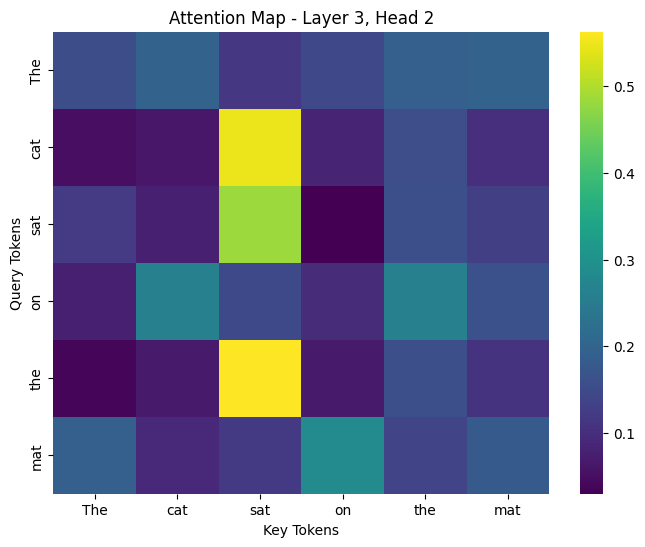

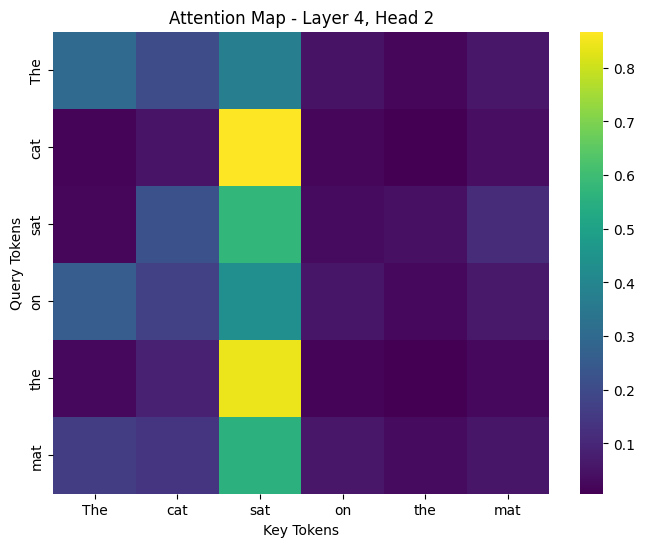

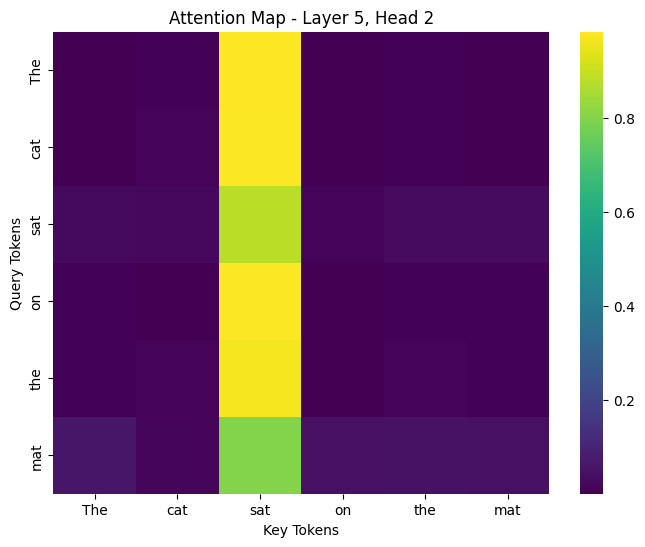

In [ ]:
plot_attention(attn_maps, layer=0, head=2, tokens=tokens)
plot_attention(attn_maps, layer=1, head=2, tokens=tokens)
plot_attention(attn_maps, layer=2, head=2, tokens=tokens)
plot_attention(attn_maps, layer=3, head=2, tokens=tokens)
plot_attention(attn_maps, layer=4, head=2, tokens=tokens)
plot_attention(attn_maps, layer=5, head=2, tokens=tokens)

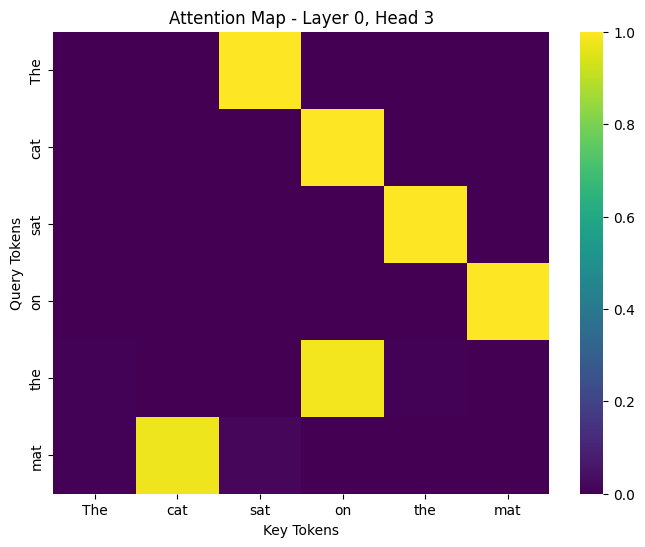

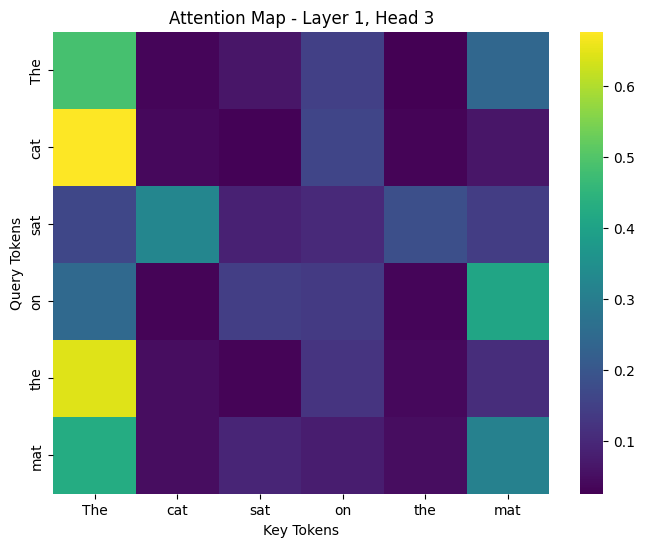

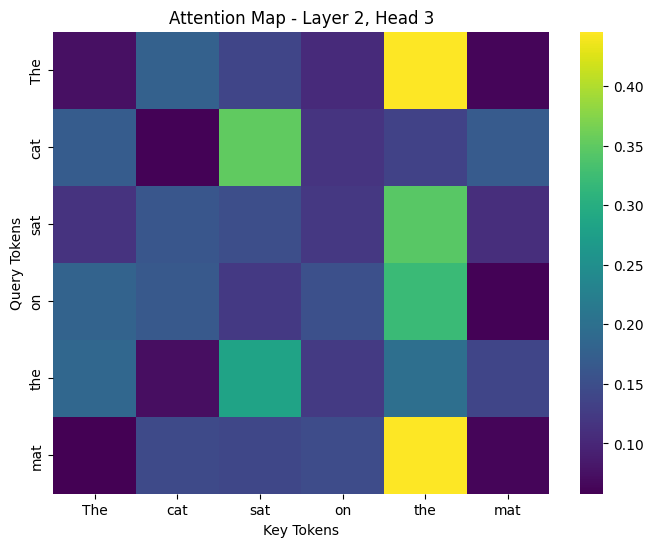

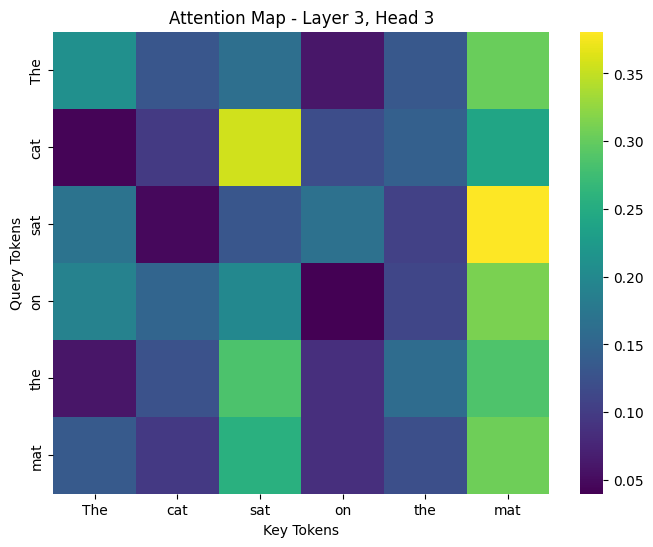

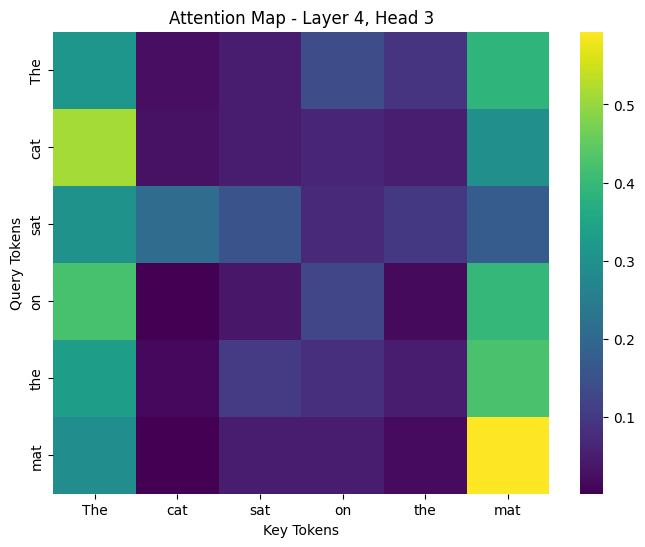

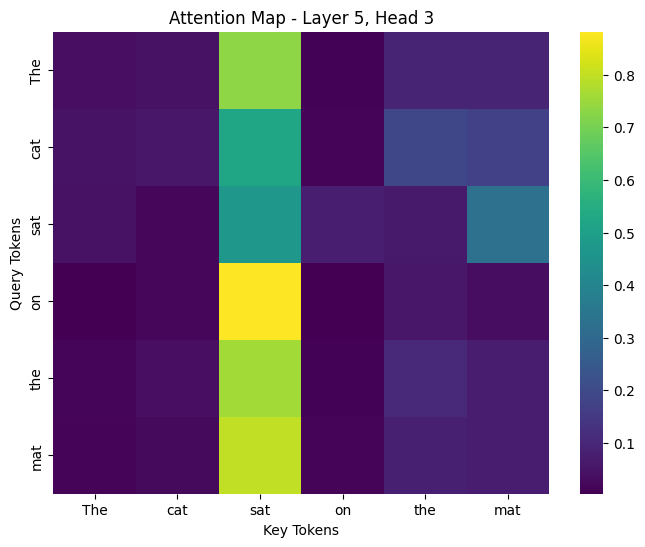

In [ ]:
plot_attention(attn_maps, layer=0, head=3, tokens=tokens)
plot_attention(attn_maps, layer=1, head=3, tokens=tokens)
plot_attention(attn_maps, layer=2, head=3, tokens=tokens)
plot_attention(attn_maps, layer=3, head=3, tokens=tokens)
plot_attention(attn_maps, layer=4, head=3, tokens=tokens)
plot_attention(attn_maps, layer=5, head=3, tokens=tokens)

# Experiments

## Text generation test

In [ ]:
def generate(model, input_ids, max_new_tokens=30, temperature=1.0, top_k=None, device='cpu'):
    model.eval()
    input_ids = input_ids.to(device)

    for _ in range(max_new_tokens):
        # Truncate input if it's longer than block size
        input_trunc = input_ids[:, -model.block_size:]

        # Get model predictions
        with torch.no_grad():
            logits = model(input_trunc)

        # Extract logits for the last position
        next_token_logits = logits[:, -1, :] / temperature

        # Top-k filtering
        if top_k is not None:
            topk_vals, topk_idx = torch.topk(next_token_logits, top_k)
            filtered_logits = torch.full_like(next_token_logits, float('-inf'))
            next_token_logits = filtered_logits.scatter(1, topk_idx, topk_vals)

        # Convert logits to probabilities
        probs = F.softmax(next_token_logits, dim=-1)

        # Sample a token from the probability distribution
        next_token = torch.multinomial(probs, num_samples=1)

        # Append the new token to the sequence
        input_ids = torch.cat([input_ids, next_token], dim=1)

    return input_ids

In [ ]:
# Load model from check point
checkpoint = torch.load("best_gpt_model_with_config.pth")

config = checkpoint['config']
model = GPT(
    vocab_size=config['vocab_size'],
    block_size=config['block_size'],
    embed_dim=config['embed_dim'],
    n_heads=config['num_heads'],
    n_layers=config['num_layers']
)

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

GPT(
  (embed): EmbeddingLayer(
    (token_embed): Embedding(8000, 128)
    (pos_embed): Embedding(128, 128)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (ff): FeedForward(
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=8000, bias=True)
)

In [ ]:
prompt = "The university student"
ids = tokenizer.encode(prompt).ids

model = model.to(device)

input_ids = torch.tensor([ids], dtype=torch.long).to(device)
output_ids = generate(model, input_ids, max_new_tokens=30, temperature=1.2, top_k=10, device=device)

decoded = tokenizer.decode(output_ids[0].tolist())

# print("Prompt:", prompt)
# print("Generated:", decoded)

In [ ]:
# Ensure the prediction(next word) is not repeating
# Since ethe dataset is small, sometimes might enter a looping

def remove_duplicates(text):
    seen = set()
    result = []
    for word in text.split():
        if word not in seen:
            seen.add(word)
            result.append(word)
    return ' '.join(result)

cleaned = remove_duplicates(decoded)

In [ ]:
print("Prompt:", prompt)
print("Generated (no repeat):", cleaned)

Prompt: The university student
Generated (no repeat): The university student Howard organization .


## Prompt Sensitivity & Sampling Strategies

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import warnings

warnings.filterwarnings("ignore")

# Load the trained tokenizer
tokenizer = Tokenizer.from_file("bpe_tokenizer.json")

# Load the saved model and configuration
checkpoint = torch.load("best_gpt_model_with_config.pth")
config = checkpoint['config']
model = GPT(
    vocab_size=config['vocab_size'],
    block_size=config['block_size'],
    embed_dim=config['embed_dim'],
    n_heads=config['num_heads'],
    n_layers=config['num_layers']
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT(
  (embed): EmbeddingLayer(
    (token_embed): Embedding(8000, 128)
    (pos_embed): Embedding(128, 128)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (ff): FeedForward(
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=8000, bias=True)
)

In [ ]:
# Define prompts with different phrasings
prompt = "The university student"

prompts = [
    "The university student",
    "A university student",
    "This university student",
    "University student",
    "The student at the university",
    "An undergrad at the college",
    "A learner enrolled in a higher education institution"
]

In [ ]:
@torch.no_grad()
def generate(model, input_tensor, max_new_tokens=30, temperature=0.7, top_k=None, device="cpu", head_mask=None ):
    model.eval()
    input_tensor = input_tensor.to(device)
    generated = input_tensor

    for _ in range(max_new_tokens):
        logits = model(generated)[:, -1, :]  # (B, vocab)
        logits = logits / temperature
        if top_k:
            top_values, _ = torch.topk(logits, top_k)
            logits[logits < top_values[:, -1].unsqueeze(1)] = -float('Inf')
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        generated = torch.cat((generated, next_token), dim=1)
    return generated

In [ ]:
outputs = []
print("="*60)

for i, prompt in enumerate(prompts):
    input_ids = tokenizer.encode(prompt).ids
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
    generated = generate(model, input_tensor, temperature=0.7, device=device)
    decoded = tokenizer.decode(generated[0].tolist())
    cleaned = remove_duplicates(decoded)

    print(f"\nPrompt {i+1}: {prompt}")
    print(f"Generated Text: {decoded}")
    outputs.append(cleaned)


Prompt 1: The university student
Generated Text: The university student The university Howard student Howard student Howard Howard Howard student Howard Howard Howard Howard student student Howard Howard Howard student Howard student Howard Howard Howard student Howard Howard and university

Prompt 2: A university student
Generated Text: A university student student student student student student student student student student student student student student student student student student student student student student student student student student student student student student students

Prompt 3: This university student
Generated Text: This university student pled student pled student pled student pled education pled student pled a pled mon student student pled student government student government student government Hait Hait government government government government university

Prompt 4: University student
Generated Text: University student University student University U

In [ ]:
# Compute BLEU similarity between outputs

print("\n" + "="*60)
print("Pairwise BLEU Similarity Between Prompt Outputs")
smoothie = SmoothingFunction().method4
for i in range(len(outputs)):
    for j in range(i + 1, len(outputs)):
        ref = outputs[i].split()
        hyp = outputs[j].split()
        score = sentence_bleu([ref], hyp, smoothing_function=smoothie)
        print(f"BLEU(Prompt {i+1} vs {j+1}): {score:.3f}")


Pairwise BLEU Similarity Between Prompt Outputs
BLEU(Prompt 1 vs 2): 0.032
BLEU(Prompt 1 vs 3): 0.021
BLEU(Prompt 1 vs 4): 0.024
BLEU(Prompt 1 vs 5): 0.013
BLEU(Prompt 1 vs 6): 0.000
BLEU(Prompt 1 vs 7): 0.000
BLEU(Prompt 2 vs 3): 0.021
BLEU(Prompt 2 vs 4): 0.043
BLEU(Prompt 2 vs 5): 0.012
BLEU(Prompt 2 vs 6): 0.000
BLEU(Prompt 2 vs 7): 0.007
BLEU(Prompt 3 vs 4): 0.009
BLEU(Prompt 3 vs 5): 0.012
BLEU(Prompt 3 vs 6): 0.000
BLEU(Prompt 3 vs 7): 0.007
BLEU(Prompt 4 vs 5): 0.010
BLEU(Prompt 4 vs 6): 0.000
BLEU(Prompt 4 vs 7): 0.000
BLEU(Prompt 5 vs 6): 0.017
BLEU(Prompt 5 vs 7): 0.010
BLEU(Prompt 6 vs 7): 0.000


In [ ]:
input_ids = tokenizer.encode(prompt).ids
input_tensor = torch.tensor([input_ids], dtype=torch.long)

# Strategy 1: Greedy-like (low temperature)
gen_1 = generate(model, input_tensor.clone(), max_new_tokens=30, temperature=0.7, top_k=None, device=device)
text_1 = tokenizer.decode(gen_1[0].tolist())
text_1 = remove_duplicates(text_1)

# Strategy 2: Top-k sampling with k=10
gen_2 = generate(model, input_tensor.clone(), max_new_tokens=30, temperature=1.0, top_k=10, device=device)
text_2 = tokenizer.decode(gen_2[0].tolist())
text_2 = remove_duplicates(text_2)

# Strategy 3: Top-k sampling with k=50
gen_3 = generate(model, input_tensor.clone(), max_new_tokens=30, temperature=1.0, top_k=50, device=device)
text_3 = tokenizer.decode(gen_3[0].tolist())
text_3

# Display generation results
print("=== Strategy 1: Temperature 0.7 (Greedy-like) ===")
print(text_1)
print("\n=== Strategy 2: Top-k (k=10) ===")
print(text_2)
print("\n=== Strategy 3: Top-k (k=50, More Creative) ===")
print(text_3)

=== Strategy 1: Temperature 0.7 (Greedy-like) ===
A learn er en ro lled in a higher education stitution ous b , their

=== Strategy 2: Top-k (k=10) ===
A learn er en ro lled in a higher education stitution ous reser workers pr their the policy is and forced .

=== Strategy 3: Top-k (k=50, More Creative) ===
A learn er en ro lled in a higher education in stitution at education around wealth the conflict education education education ne high education @-@ fre fre aged education aging hy ous learn education in per education local a set per learn


## Head Ablation

In [ ]:
# Reuse the trained model with best hyperparameters - used Adam optimizer

checkpoint = torch.load("best_gpt_model_with_config.pth", map_location=device)

config = checkpoint['config']
adam_model = GPT(config['vocab_size'], config['embed_dim'], config['block_size'],
            config['num_heads'], config['num_layers']).to(device)

adam_model.load_state_dict(checkpoint['model_state_dict'])
adam_model.eval()

In [ ]:
# Define an input prompt
prompt = "The cat sat on"

# Tokenize the prompt and convert to a tensor of token IDs
input_ids = torch.tensor([tokenizer.encode(prompt).ids])  # shape: (1, T)

# Define a head mask to disable certain attention heads
# In this example, we assume the model has 4 attention heads.
# Set 0 to disable a head, and 1 to keep it active.
# Here, heads 1 and 2 are disabled (index starts from 0).
head_mask = torch.tensor([1, 0, 0, 1], dtype=torch.float32).to(device)  # shape: (n_heads,)

In [ ]:
# Generate text with the specified head mask (ablating heads 1 and 2)
output_ids = generate(
    model,
    input_ids,
    max_new_tokens=20,
    temperature=1.0,
    top_k=10,
    device=device,
    head_mask=head_mask
)

# Decode and print the result
output_text = tokenizer.decode(output_ids[0].tolist())
print("Prompt:", prompt)
print("Generated Text:", output_text)

Prompt: The cat sat on
Generated Text: The cat sat on on on Mul on Mul on Mul on Mul on Mul Mul Mul on Mul Mul on Mul Mul Mul
